### **Installing NLTK and Gensim packages**

In [ ]:
!pip install nltk
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


### **Importing Python Libraries**

In [ ]:
import nltk
import numpy as np
from nltk.corpus import brown
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
import gensim

### **Downloading Brown Corpus**

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### **One-Hot Encoding for POS Tags**

In [ ]:
def get_one_hot_encoding(arg_tags,tag) :
  return [int(i==tag) for i in arg_tags]

### **Extracting words from sentences**

In [ ]:
def sents_to_words(sents_data):
  words_data = []
  for sent_index in range(len(sents_data)):
    for word_index in range(len(sents_data[sent_index])): 
      words_data.append(sents_data[sent_index][word_index])
  return words_data

### **Defining the tagset**

In [ ]:
corpus_words = nltk.corpus.brown.tagged_words(tagset='universal') 
tags = list(set([i[1] for i in corpus_words])) # Unique tags
tags.sort()
tag_index = dict(zip(tags, range(len(tags))))
index_to_tag = dict(zip(range(len(tags)),tags))
one_hot_encoding = {}
for tag in tags :
  one_hot_encoding[tag] = get_one_hot_encoding(tags,tag)

### **Extracting sentences from Brown Corpus**

In [ ]:
corpus_sents = np.asarray(nltk.corpus.brown.tagged_sents(tagset='universal'))
discard = []
for i in range(len(corpus_sents)):
  if(len(corpus_sents[i])==1 and corpus_sents[i][0][1]=='.'):
    discard.append(i)
corpus_sents = np.delete(corpus_sents, discard)
corpus_sents = corpus_sents.tolist()
for i in range(len(corpus_sents)):
  if corpus_sents[i][-1][1] == '.':
    corpus_sents[i] = corpus_sents[i][:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


### **Separate the tags from words**

In [ ]:
embed_sents = []
embed_tags = []
for i in range(len(corpus_sents)) :
  temp_sent = []
  temp_tags = []
  for j in range(len(corpus_sents[i])) :
    temp_sent.append(corpus_sents[i][j][0])
    temp_tags.append(corpus_sents[i][j][1])
  embed_sents.append(temp_sent)
  embed_tags.append(temp_tags)
embed_sents = np.asarray(embed_sents)
embed_tags = np.asarray(embed_tags)

### **Deleting Unnecessary variables**

Don't run this during testing

In [ ]:
del corpus_sents
del temp_sent
del temp_tags

### **Define the Tensorflow Model**

Run this if you don't have the saved Tensorflow model

In [ ]:
def model_1(embedding_size, window_size):
  model = Sequential([
      Flatten(input_shape = (2*window_size + 1,embedding_size)),
      Dense(embedding_size,activation="relu"),
      Dense(embedding_size/2,activation="relu"),
      Dense(12,activation="softmax")
  ])
  return model

### **Hyperparameter Tuning**

In [ ]:
embedding_size = 100      # Dimension of word vectors
window_size = 1           # Number of words around the target word that will be considered while training the model
epochs = 5                # Number of epochs

### **Generate Word2Vec model using Brown corpus**

In [ ]:
brown_wvmodel = gensim.models.Word2Vec(sentences=embed_sents, vector_size=embedding_size).wv

### **Generate training data**

Run this if you don't have the saved Tensorflow model

In [ ]:
def transform_w2v_train(training_sents, training_tags, arg_wvmodel, embedding_size, window_size) :
  w2v_words = []
  w2v_tags = []
  for i in range(len(training_sents)) :
    sent = training_sents[i]
    for p in range(len(sent)):
      vec = np.zeros((2*window_size+1,embedding_size), dtype=np.float32)
      append_plz = True
      for j in list(np.arange(p-window_size,p+window_size+1)) :
        if j>=0 and j<len(sent) :
          try:
            vec[j-p+window_size] = arg_wvmodel.get_vector(sent[j],norm=True)
          except:
            append_plz = False
            break
      if append_plz:
        w2v_words.append(vec)
        w2v_tags.append(one_hot_encoding[training_tags[i][p]])
  return np.asarray(w2v_words), np.asarray(w2v_tags)

### **Training the model**

Don't run this during testing

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, random_state=None, shuffle=True)
iter = 0
# batches = 10
for train,test in kfold.split(embed_sents):
  print("#"*15 + " Iteration " + str(iter) + " " + "#"*15)
  print()
  iter+=1
  # Initialising the Tensorflow model
  kfold_model = model_1(embedding_size, window_size)
  kfold_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.FalseNegatives()])
  # Generating Training Data
  training_words_data, training_tags = transform_w2v_train(embed_sents[train], embed_tags[train], brown_wvmodel, embedding_size, window_size)
  # Training the model
  kfold_model.fit(training_words_data,training_tags,epochs=epochs)
  print()
  del training_words_data
  del training_tags
  # Saving the Model and Data
  kfold_model.save(f'saved_model/my_model_{iter}')
  with open(f'training_{iter}.txt', 'w') as f:
    for sent in embed_sents[train]:
      for word in sent:
        f.write(f"{word} ")
      f.write("\n")
  with open(f'test_data_{iter}.txt', 'w') as f:
    for sent in embed_sents[test]:
      for word in sent:
        f.write(f"{word} ")
      f.write("\n")
  with open(f'test_tags_{iter}.txt', 'w') as f:
    for sent in embed_tags[test]:
      for tag in sent:
        f.write(f"{tag} ")
      f.write("\n")
  tf.keras.backend.clear_session()

############### Iteration 0 ###############

Epoch 1/5
23275/23275 [==============================] - 79s 3ms/step - loss: 0.2590 - accuracy: 0.9112 - false_negatives: 80576.0000
Epoch 2/5
23275/23275 [==============================] - 79s 3ms/step - loss: 0.1921 - accuracy: 0.9328 - false_negatives: 58468.0000
Epoch 3/5
23275/23275 [==============================] - 78s 3ms/step - loss: 0.1766 - accuracy: 0.9378 - false_negatives: 53821.0000
Epoch 4/5
23275/23275 [==============================] - 94s 4ms/step - loss: 0.1664 - accuracy: 0.9416 - false_negatives: 50312.0000
Epoch 5/5
23275/23275 [==============================] - 78s 3ms/step - loss: 0.1595 - accuracy: 0.9435 - false_negatives: 48326.0000

############### Iteration 1 ###############

Epoch 1/5
23314/23314 [==============================] - 69s 3ms/step - loss: 0.2623 - accuracy: 0.9101 - false_negatives: 81600.0000
Epoch 2/5
23314/23314 [==============================] - 72s 3ms/step - loss: 0.1942 - accuracy: 0.9318 -

### **Import Google-News-300 Dataset**

In [ ]:
import gensim.downloader

google_wvmodel = gensim.downloader.load('word2vec-google-news-300')
google_embedding_size = 300

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### **Generate an Embedding Matrix consisting of word vectors from Google Dataset**

In [ ]:
def google_matrix(common_words):
  matrix = np.zeros((len(common_words), google_embedding_size))
  for i in range(len(common_words)):
    matrix[i] = google_wvmodel.get_vector(common_words[i], norm=True)
  return matrix

### **Find the most similar word in the training corpus**

In [ ]:
def most_similar(word, word2vec_matrix, common_words):
  try:
    test_vector = google_wvmodel.get_vector(word, norm=True)
    similarity_vector = np.matmul(word2vec_matrix, test_vector)
    return common_words[np.argmax(similarity_vector)]
  except:
    return ""

### **Generate Test Data**

Don't run this during testing

In [ ]:
def transform_w2v_test(test_sents,test_tags,arg_wvmodel,embedding_size,window_size,available_words,embedding_matrix) :
  w2v_words = []
  w2v_tags = []
  for i in range(len(test_sents)) :
    sent = test_sents[i]
    for p in range(len(sent)):
      vec = np.zeros((2*window_size+1,embedding_size))
      for j in list(np.arange(p-window_size,p+window_size+1)) :
        if j>=0 and j<len(sent) :
          try:
            vec[j-p+window_size] = arg_wvmodel.get_vector(sent[j], norm=True)
          except:
              similar_word = most_similar(sent[j], available_words, embedding_matrix)
              if len(similar_word) == 0 :
                v = np.random.rand(embedding_size)
                vec[j-p+window_size] = v/np.linalg.norm(v)
              else:
                vec[j-p+window_size] = arg_wvmodel.get_vector(similar_word, norm=True)
      w2v_words.append(vec)
      w2v_tags.append(one_hot_encoding[test_tags[i][p]])
  return np.asarray(w2v_words), np.asarray(w2v_tags)

### **Auxiliary Function**

Don't run this during testing

In [ ]:
def trim(s):
  return s[:-2].split()

### **Finding common words between Brown Corpus and Google News Dataset**

In [ ]:
unique_words = list(set([i[0] for i in corpus_words]))
google_words = []
for index, word in enumerate(google_wvmodel.index_to_key):
  google_words.append(word)
common_words = list(set(google_words).intersection(set(unique_words)))
del google_words
del corpus_words

### **Performing K-Fold Cross Validation on the model**

Don't run this during testing

In [ ]:
confusion_matrix = np.zeros((12,12))
confusion_matrix = confusion_matrix.astype('float64')
accuracy = []
for iter in range(5):
  print("#"*15 + " Fold : " + str(iter+1) + " " + "#"*15)
  # Extract training data
  train_file = open(f"training_{iter+1}.txt", 'r')
  training_data = train_file.readlines()
  training_data = list(map(trim, training_data))
  training_words = sents_to_words(training_data)
  training_words = list(set([i[0] for i in training_words]))
  available_words = list(set(common_words).intersection(set(training_words)))
  # Delete training variables
  del training_words
  del training_data
  # Generating the matrix of word vectors from Google News dataset
  word2vec_matrix = google_matrix(available_words)
  # Extract test data
  test_data_file = open(f"test_data_{iter+1}.txt", 'r')
  test_data = test_data_file.readlines()
  test_data = list(map(trim, test_data))
  test_tags_file = open(f"test_tags_{iter+1}.txt", 'r')
  test_tags = test_tags_file.readlines()
  test_tags = list(map(trim, test_tags))
  # Generating word vectors for test data
  testing_words_data, testing_tags = transform_w2v_test(test_data, test_tags, brown_wvmodel, embedding_size, window_size, available_words, word2vec_matrix)
  del test_data
  del test_tags
  # Load the Keras Model for Cross Validation
  kfold_model = tf.keras.models.load_model(f'saved_model/my_model_{iter+1}')
  correct_tags = 0
  total_tags = 0
  for i in range(len(testing_words_data)) :
    expected = np.argmax(testing_tags[i])
    predicted = np.argmax(kfold_model(testing_words_data[i][None,:,:], training=False))
    confusion_matrix[expected][predicted] += 1
    if expected == predicted :
      correct_tags += 1
    total_tags += 1
  accuracy.append(correct_tags/total_tags)
  # Delete space-consuming variables
  del word2vec_matrix
  del available_words
  del testing_words_data
  del testing_tags
final_accuracy = np.mean(accuracy)

### **Calculating Precision, Recall and F-scores**

Don't run this during testing

In [ ]:
def Fscore(beta,precision,recall):
  return (1+beta*beta)*precision*recall/(beta*beta*precision + recall)

In [ ]:
precision = []
recall = []
for i in range(len(confusion_matrix)):
  precision.append(confusion_matrix[i][i]/sum(confusion_matrix[:,i]))
  recall.append(confusion_matrix[i][i]/sum(confusion_matrix[i]))
F1_score = []
F2_score = []
Fhalf_score = []
for i in range(len(recall)):
  F1_score.append(Fscore(1,precision[i],recall[i]))
  F2_score.append(Fscore(2,precision[i],recall[i]))
  Fhalf_score.append(Fscore(0.5,precision[i],recall[i]))
net_precision = np.mean(precision)
net_recall = np.mean(recall)
net_F1_score = np.mean(F1_score)
net_F2_score = np.mean(F2_score)
net_Fhalf_score = np.mean(Fhalf_score)
print("Net Accuracy : " + str(format(final_accuracy*100, '.2f')))
print("Net precision : " + str(format(net_precision*100, '.2f')))
print("Net Recall : " + str(format(net_recall*100, '.2f')))
print("Net F1 Score : " + str(format(net_F1_score*100, '.2f')))
print("Net F2 Score : " + str(format(net_F2_score*100, '.2f')))
print("Net F3 Score : " + str(format(net_Fhalf_score*100, '.2f')))

In [ ]:
print("Precision per POS Tag")
print(precision)
print()
print("Recall per POS Tag")
print(recall)
print()
print("F1 score per POS Tag")
print(F1_score)
print()
print("F2 score per POS Tag")
print(F2_score)
print()
print("F0.5 score per POS Tag")
print(Fhalf_score)

### **Plotting the heat map for confusion matrix**

Don't run this during testing

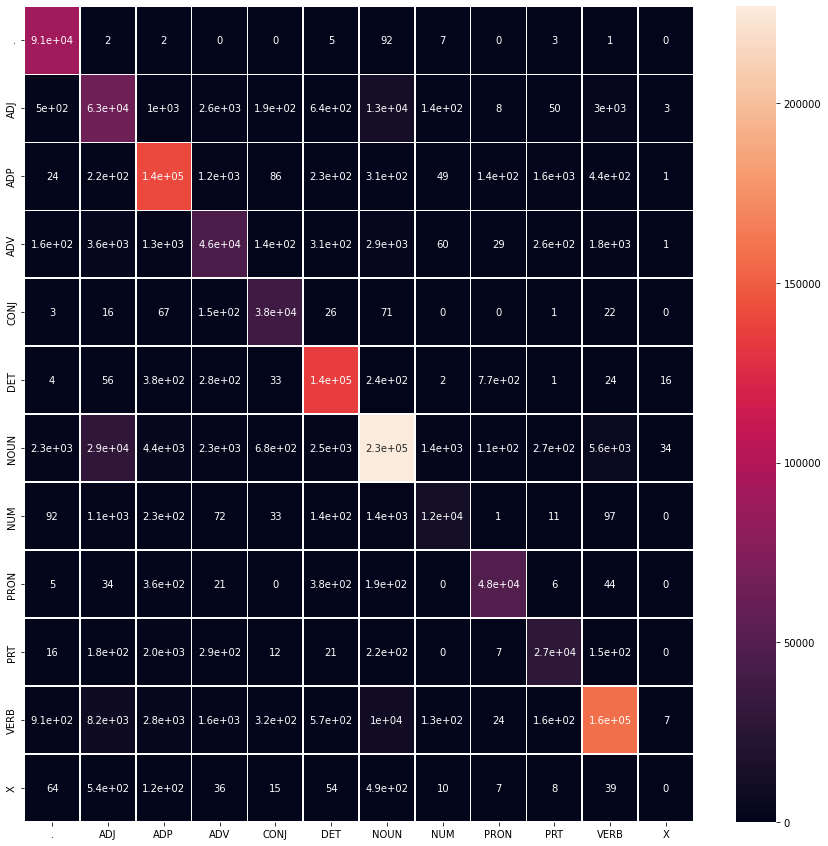

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

c = np.empty((len(confusion_matrix),len(confusion_matrix)))
for i in range(len(confusion_matrix)):
  for j in range(len(confusion_matrix)):
    c[i][j] = round(confusion_matrix[i][j],2)
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(c, annot=True, linewidths=.5, ax=ax, xticklabels=tags, yticklabels=tags)

### **Final Training**

Run this if you don't have the saved Tensorflow model

In [ ]:
# Generate Training Data
training_words_data, training_tags = transform_w2v_train(embed_sents, embed_tags, brown_wvmodel, embedding_size, window_size)

#Initialize Tensorflow Model
final_model = model_1(embedding_size, window_size)
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.FalseNegatives()])

# Perform Training 
final_model.fit(training_words_data,training_tags,epochs=epochs)

# Save the Tensorflow Model
final_model.save('final_model')

Epoch 1/5
29104/29104 [==============================] - 71s 2ms/step - loss: 0.2490 - accuracy: 0.9146 - false_negatives: 95988.0000
Epoch 2/5
29104/29104 [==============================] - 68s 2ms/step - loss: 0.1871 - accuracy: 0.9344 - false_negatives: 71256.0000
Epoch 3/5
29104/29104 [==============================] - 68s 2ms/step - loss: 0.1727 - accuracy: 0.9390 - false_negatives: 65858.0000
Epoch 4/5
29104/29104 [==============================] - 67s 2ms/step - loss: 0.1639 - accuracy: 0.9419 - false_negatives: 62477.0000
Epoch 5/5
29104/29104 [==============================] - 68s 2ms/step - loss: 0.1575 - accuracy: 0.9442 - false_negatives: 59919.0000


### **Get Input Vectors for words present in the input sentence**

In [ ]:
def transform(sent,arg_wvmodel,embedding_size,window_size,available_words,embedding_matrix) :
  w2v_words = []
  for p in range(len(sent)):
    vec = np.zeros((2*window_size+1,embedding_size))
    for j in list(np.arange(p-window_size,p+window_size+1)) :
      if j>=0 and j<len(sent) :
        try:
          # Word is present in Brown Corpus
          vec[j-p+window_size] = arg_wvmodel.get_vector(sent[j], norm=True)
        except:
            similar_word = most_similar(sent[j], available_words, embedding_matrix)
            # Word is not present in Google corpus as well
            if len(similar_word) == 0 :
              v = np.random.rand(embedding_size)
              vec[j-p+window_size] = v/np.linalg.norm(v)
            # Word is present in Google corpus
            else:
              vec[j-p+window_size] = arg_wvmodel.get_vector(similar_word, norm=True)
    w2v_words.append(vec)
  return np.asarray(w2v_words)

### **Load a saved Tensorflow Model**

In [ ]:
final_model = tf.keras.models.load_model('/content/content/final_model') #path to the final_model folder

### **Performing POS tagging on user input sentence**

In [ ]:
input_sentence = input()
lst = nltk.word_tokenize(input_sentence)
word2vec_matrix = google_matrix(common_words)
testing_words_data = transform(lst, brown_wvmodel, embedding_size, window_size, common_words, word2vec_matrix)
tagged_list = []
for i in range(len(testing_words_data)) :
  tagged_list.append(index_to_tag[np.argmax(final_model(testing_words_data[i][None,:,:], training=False))])
print(tagged_list)

Netflix
['ADJ']


In [ ]:
!zip -r '/content/model.zip' '/content/final_model'